In [1]:
import pandas as pd
matches=pd.read_csv("C:\\Users\\Bhavani\Downloads\matches.csv")
deliveries=pd.read_csv("C:\\Users\\Bhavani\Downloads\deliveries.csv")


In [2]:
matches_selected = matches[[
    "match_id", "date", "venue", "team1", "team2", "toss_winner", "toss_decision",
    "winner", "result", "result_margin"
]]

deliveries_selected = deliveries[[
    "match_id", "inning", "batting_team", "bowling_team", "over", "ball",
    "total_runs", "is_wicket"
]]

merged_df = deliveries_selected.merge(matches_selected, on="match_id", how="left")
merged_df["cumulative_runs"] = merged_df.groupby(["match_id", "inning"])["total_runs"].cumsum()
merged_df["cumulative_wickets"] = merged_df.groupby(["match_id", "inning"])["is_wicket"].cumsum()
merged_df["overs_completed"] = merged_df["over"] + (merged_df["ball"] / 6)
merged_df["current_run_rate"] = merged_df["cumulative_runs"] / merged_df["overs_completed"].replace(0, 1)

merged_df['target_score'] = merged_df.groupby('match_id')['cumulative_runs'].transform('max') + 1

total_overs = 50
merged_df['remaining_overs'] = total_overs - merged_df['overs_completed']

merged_df['remaining_overs'] = merged_df['remaining_overs'].replace(0, 1)

merged_df['required_run_rate'] = (merged_df['target_score'] - merged_df['cumulative_runs']) / merged_df['remaining_overs']

merged_df = merged_df.rename(columns={
    "team1": "home_team",
    "team2": "away_team"
})
team_mapping = {
    "Royal Challengers Bengaluru": "Royal Challengers Bangalore",
    "Rising Pune Supergiant": "Rising Pune Supergiants",
    "Delhi Daredevils": "Delhi Capitals",
    "Kings XI Punjab": "Punjab Kings"
}
merged_df['winner'] = merged_df['winner'].replace(team_mapping)
merged_df['home_team'] = merged_df['home_team'].replace(team_mapping)
merged_df['away_team'] = merged_df['away_team'].replace(team_mapping)


In [3]:
merged_df.head()


,match_id,inning,batting_team,bowling_team,over,ball,total_runs,is_wicket,date,venue,...,winner,result,result_margin,cumulative_runs,cumulative_wickets,overs_completed,current_run_rate,target_score,remaining_overs,required_run_rate
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,1,0,4/18/2008,M Chinnaswamy Stadium,...,Kolkata Knight Riders,runs,140.0,1,0,0.166667,6.0,223,49.833333,4.454849
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,0,0,4/18/2008,M Chinnaswamy Stadium,...,Kolkata Knight Riders,runs,140.0,1,0,0.333333,3.0,223,49.666667,4.469799
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,1,0,4/18/2008,M Chinnaswamy Stadium,...,Kolkata Knight Riders,runs,140.0,2,0,0.500000,4.0,223,49.500000,4.464646
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,0,0,4/18/2008,M Chinnaswamy Stadium,...,Kolkata Knight Riders,runs,140.0,2,0,0.666667,3.0,223,49.333333,4.479730
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,0,0,4/18/2008,M Chinnaswamy Stadium,...,Kolkata Knight Riders,runs,140.0,2,0,0.833333,2.4,223,49.166667,4.494915


In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260920 entries, 0 to 260919
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   match_id            260920 non-null  int64  
 1   inning              260920 non-null  int64  
 2   batting_team        260920 non-null  object 
 3   bowling_team        260920 non-null  object 
 4   over                260920 non-null  int64  
 5   ball                260920 non-null  int64  
 6   total_runs          260920 non-null  int64  
 7   is_wicket           260920 non-null  int64  
 8   date                260920 non-null  object 
 9   venue               260920 non-null  object 
 10  home_team           260920 non-null  object 
 11  away_team           260920 non-null  object 
 12  toss_winner         260920 non-null  object 
 13  toss_decision       260920 non-null  object 
 14  winner              260430 non-null  object 
 15  result              260920 non-nul

In [5]:
merged_df["winner"].fillna("No Result", inplace=True)
merged_df["result_margin"].fillna(0, inplace=True)
merged_df.to_csv("merged_dataset.csv", index=False)

In [6]:
merged_df.isnull().sum()

match_id              0
inning                0
batting_team          0
bowling_team          0
over                  0
ball                  0
total_runs            0
is_wicket             0
date                  0
venue                 0
home_team             0
away_team             0
toss_winner           0
toss_decision         0
winner                0
result                0
result_margin         0
cumulative_runs       0
cumulative_wickets    0
overs_completed       0
current_run_rate      0
target_score          0
remaining_overs       0
required_run_rate     0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
import pandas as pd

# Assume merged_df is already loaded
final_df = merged_df.copy()

# ✅ Initialize separate LabelEncoders
le_batting = LabelEncoder()
le_bowling = LabelEncoder()
le_venue = LabelEncoder()
le_winner = LabelEncoder()

# ✅ Encode categorical features separately
final_df["batting_team_encoded"] = le_batting.fit_transform(final_df["batting_team"])
final_df["bowling_team_encoded"] = le_bowling.fit_transform(final_df["bowling_team"])
final_df["venue_encoded"] = le_venue.fit_transform(final_df["venue"])

# ✅ Save each LabelEncoder separately
joblib.dump(le_batting, "label_batting.pkl")
joblib.dump(le_bowling, "label_bowling.pkl")
joblib.dump(le_venue, "label_venue.pkl")

# ✅ Encode winner column correctly
if "winner" in final_df.columns:
    final_df["winner_encoded"] = le_winner.fit_transform(final_df["winner"])
    final_df["win"] = (final_df["batting_team_encoded"] == final_df["winner_encoded"]).astype(int)
    joblib.dump(le_winner, "label_winner.pkl")  # Save LabelEncoder for winner
else:
    raise KeyError("❌ Column 'winner' is missing after merging. Check the dataset.")

# ✅ Select final columns
final_df = final_df[[
    "inning", "cumulative_runs", "cumulative_wickets", "current_run_rate",
    "required_run_rate", "target_score", "batting_team_encoded",
    "bowling_team_encoded", "venue_encoded", "overs_completed", "win"
]]

# === 🏋️ Train-Test Split ===
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42, stratify=final_df["win"])

# ✅ Save dataset
final_df.to_csv("final_dataset.csv", index=False)

print(f"✅ Encoding completed! Train: {train_df.shape}, Test: {test_df.shape}")


✅ Encoding completed! Train: (208736, 11), Test: (52184, 11)


In [8]:
final_df.to_csv("final_dataset.csv", index=False)
final_df.head()


,inning,cumulative_runs,cumulative_wickets,current_run_rate,required_run_rate,target_score,batting_team_encoded,bowling_team_encoded,venue_encoded,overs_completed,win
0,1,1,0,6.0,4.454849,223,8,16,23,0.166667,0
1,1,1,0,3.0,4.469799,223,8,16,23,0.333333,0
2,1,2,0,4.0,4.464646,223,8,16,23,0.500000,0
3,1,2,0,3.0,4.479730,223,8,16,23,0.666667,0
4,1,2,0,2.4,4.494915,223,8,16,23,0.833333,0


Accuracy: 1.0000
Confusion Matrix:
[[45786     2]
 [    0  6396]]


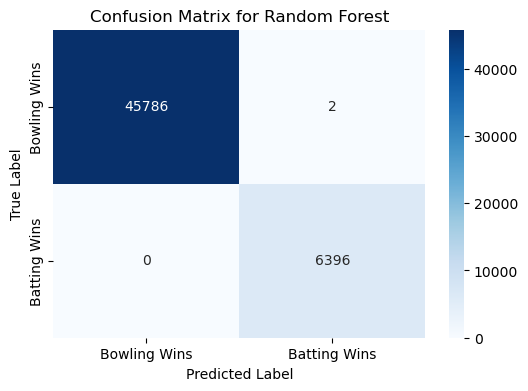

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45788
           1       1.00      1.00      1.00      6396

    accuracy                           1.00     52184
   macro avg       1.00      1.00      1.00     52184
weighted avg       1.00      1.00      1.00     52184

Predicted Winner: Bowling Team Wins


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
 

X = final_df.drop(columns=["win"])  
y = final_df["win"]  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bowling Wins", "Batting Wins"], yticklabels=["Bowling Wins", "Batting Wins"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

plot_confusion_matrix(y_test, y_pred, "Random Forest")

print("Classification Report:")
print(class_report)

new_match_data = {
    "inning": [1],  
    "cumulative_runs": [80],
    "cumulative_wickets": [5],
    "current_run_rate": [12.0],
    "required_run_rate": [5.5],
    "target_score": [150],
    "batting_team_encoded": [2],  
    "bowling_team_encoded": [3],  
    "venue_encoded": [1],  
    "overs_completed":[12.0],
}

new_match_df = pd.DataFrame(new_match_data)
new_match_prediction = rf_model.predict(new_match_df)

if new_match_prediction[0] == 1:
    print("Predicted Winner: Batting Team Wins")
else:
    print("Predicted Winner: Bowling Team Wins")


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib


rf_params = {
    "n_estimators": [50, 100, 200], 
    "max_depth": [10, 20, None], 
    "min_samples_split": [2, 5],  
    "min_samples_leaf": [1, 2],  
    "bootstrap": [True, False]
}

rf = RandomForestClassifier(random_state=42)

rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=5, cv=2, scoring="accuracy", n_jobs=4, random_state=42
)

rf_search.fit(X_train, y_train)

print("\nBest Random Forest Parameters:", rf_search.best_params_)

final_rf_model = rf_search.best_estimator_

final_rf_model.fit(X_train, y_train)

y_pred_rf = final_rf_model.predict(X_test)


print("\nRandom Forest Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

joblib.dump(final_rf_model, 'final_rf_model.pkl')



Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Random Forest Model Performance:
Accuracy: 1.0000
Confusion Matrix:
 [[45788     0]
 [    0  6396]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45788
           1       1.00      1.00      1.00      6396

    accuracy                           1.00     52184
   macro avg       1.00      1.00      1.00     52184
weighted avg       1.00      1.00      1.00     52184



['final_rf_model.pkl']

C:\Users\Bhavani\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6491
Confusion Matrix:
[[24576  6083]
 [12226  9299]]


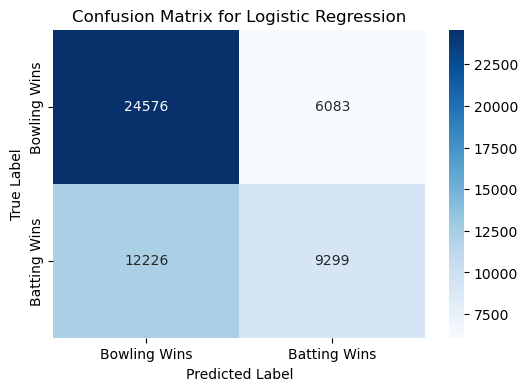

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73     30659
           1       0.60      0.43      0.50     21525

    accuracy                           0.65     52184
   macro avg       0.64      0.62      0.62     52184
weighted avg       0.64      0.65      0.64     52184

Predicted Winner: Bowling Team Wins


In [12]:
from sklearn.linear_model import LogisticRegression



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


log_model = LogisticRegression(random_state=42)
log_model.fit(X_train, y_train)


y_pred = log_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bowling Wins", "Batting Wins"], yticklabels=["Bowling Wins", "Batting Wins"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

plot_confusion_matrix(y_test, y_pred, "Logistic Regression")

print("Classification Report:")
print(class_report)

new_match_data = {
    "inning": [1],  
    "cumulative_runs": [100],
    "cumulative_wickets": [2],
    "current_run_rate": [6.0],
    "required_run_rate": [5.5],
    "target_score": [150],
    "batting_team_encoded": [2],  
    "bowling_team_encoded": [3],  
    "venue_encoded": [1],  
}

new_match_df = pd.DataFrame(new_match_data)
new_match_prediction = log_model.predict(new_match_df)

if new_match_prediction[0] == 1:
    print("Predicted Winner: Batting Team Wins")
else:
    print("Predicted Winner: Bowling Team Wins")


C:\Users\Bhavani\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9919
Confusion Matrix:
[[30421   238]
 [  183 21342]]


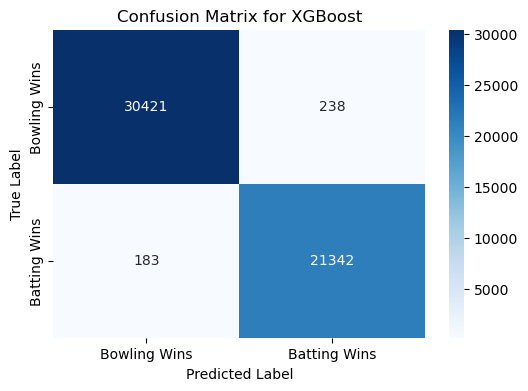

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     30659
           1       0.99      0.99      0.99     21525

    accuracy                           0.99     52184
   macro avg       0.99      0.99      0.99     52184
weighted avg       0.99      0.99      0.99     52184

Predicted Winner: Bowling Team Wins


In [13]:
from xgboost import XGBClassifier



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Bowling Wins", "Batting Wins"], 
                yticklabels=["Bowling Wins", "Batting Wins"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
plot_confusion_matrix(y_test, y_pred, "XGBoost") 
print("Classification Report:")
print(class_report)

new_match_data = {
    "inning": [1],  
    "cumulative_runs": [100],
    "cumulative_wickets": [2],
    "current_run_rate": [6.0],
    "required_run_rate": [5.5],
    "target_score": [150],
    "batting_team_encoded": [2],  
    "bowling_team_encoded": [3],  
    "venue_encoded": [1],  
}

new_match_df = pd.DataFrame(new_match_data)
new_match_prediction = xgb_model.predict(new_match_df)

if new_match_prediction[0] == 1:
    print("Predicted Winner: Batting Team Wins")
else:
    print("Predicted Winner: Bowling Team Wins")


C:\Users\Bhavani\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.8796
Confusion Matrix:
[[27411  3248]
 [ 3033 18492]]


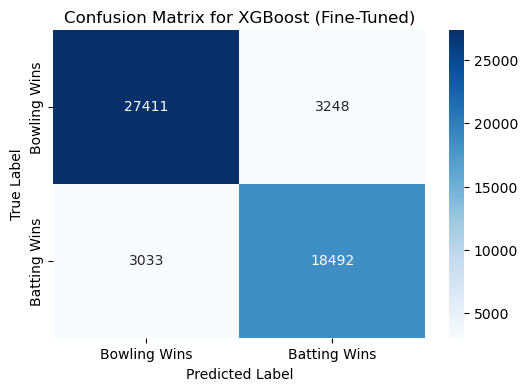

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     30659
           1       0.85      0.86      0.85     21525

    accuracy                           0.88     52184
   macro avg       0.88      0.88      0.88     52184
weighted avg       0.88      0.88      0.88     52184

Predicted Winner: Bowling Team Wins


In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, use_label_encoder=False, eval_metric="logloss")


param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=10, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_


y_pred = best_xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bowling Wins", "Batting Wins"], yticklabels=["Bowling Wins", "Batting Wins"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

print(f"Best Parameters: {random_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

plot_confusion_matrix(y_test, y_pred, "XGBoost (Fine-Tuned)")

print("Classification Report:")
print(class_report)

new_match_data = {
    "inning": [1],  
    "cumulative_runs": [100],
    "cumulative_wickets": [2],
    "current_run_rate": [6.0],
    "required_run_rate": [5.5],
    "target_score": [150],
    "batting_team_encoded": [2],  
    "bowling_team_encoded": [3],  
    "venue_encoded": [1],  
}

new_match_df = pd.DataFrame(new_match_data)
new_match_prediction = best_xgb_model.predict(new_match_df)

if new_match_prediction[0] == 1:
    print("Predicted Winner: Batting Team Wins")
else:
    print("Predicted Winner: Bowling Team Wins")


C:\Users\Bhavani\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy: 0.6306

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.96      0.75     30659
           1       0.74      0.16      0.26     21525

    accuracy                           0.63     52184
   macro avg       0.68      0.56      0.51     52184
weighted avg       0.67      0.63      0.55     52184



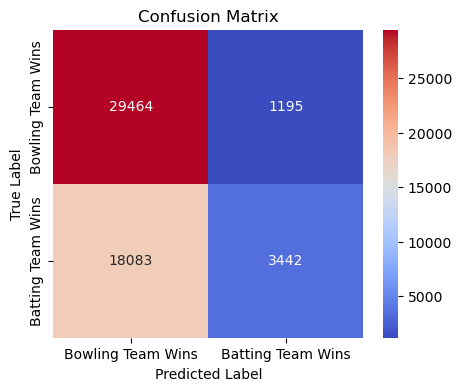

Predicted Winner: Bowling Team Wins


In [15]:
from sklearn.linear_model import SGDClassifier  


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

svm_model = SGDClassifier(loss="hinge", max_iter=500, random_state=42)
svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", class_report)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Bowling Team Wins", "Batting Team Wins"], yticklabels=["Bowling Team Wins", "Batting Team Wins"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


new_match_data = {
    "inning": [1],  
    "cumulative_runs": [100],
    "cumulative_wickets": [2],
    "current_run_rate": [6.0],
    "required_run_rate": [5.5],
    "target_score": [150],
    "batting_team_encoded": [2],  
    "bowling_team_encoded": [3],  
    "venue_encoded": [1],  
}

new_match_df = pd.DataFrame(new_match_data)
new_match_prediction = svm_model.predict(new_match_df)


print("Predicted Winner:", "Batting Team Wins" if new_match_prediction[0] == 1 else "Bowling Team Wins")
